In [1]:
import mne

import numpy as np
import matplotlib.pyplot as plt
from mne import Epochs, pick_types
from mne.decoding import CSP
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.covariance import LedoitWolf, OAS
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
import json


In [2]:



# Replace 'your_file.gbf' with the path to your GBF file
file_path = '../thesis_data/arne_03_05/Testdata_tt3.bdf'
# file_path = 'ly_04_07/Testdata_ly_imag_01.bdf'
# Load the BDF file
raw = mne.io.read_raw_bdf(file_path, preload=True)

# Print some information about the loaded data
print(raw.info)
# Print channel names
print(raw.ch_names)

# Specify the channel name you are interested in
channel_name = 'Status'  # Replace with the actual channel name

# Get the index of the specified channel
channel_index = raw.ch_names.index(channel_name)

# Get the data for the specified channel
channel_data = raw.get_data()[channel_index]

# Print unique values in the channel
unique_values = set(channel_data)
print("Unique values in channel '{}':".format(channel_name))
for value in unique_values:
    print("{}---{}".format(value,hex(int(value))))

# Specify the value you want to count
value_to_count = 128  # Replace with the value you want to count

# Count occurrences of the specified value using Python's count() function
count_python = channel_data.tolist().count(value_to_count)
print("Occurrences of value {} in channel '{}': {}".format(value_to_count, channel_name, count_python))
array_int = channel_data.astype(int)
channel_trigger = np.right_shift(array_int,5) & 0x7


Extracting EDF parameters from /Users/reniflalebenezer/thesis_data/arne_03_05/Testdata_tt3.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 679935  =      0.000 ...   332.000 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, ...
 chs: 271 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 417.0 Hz
 meas_date: 2024-05-03 12:40:04 UTC
 nchan: 272
 projs: []
 sfreq: 2048.0 Hz
 subject_info: 1 item (dict)
>
['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'C1', 'C2', 'C3', 'C

In [3]:
# Specify the value you want to track changes for
value_to_track = 2  # Replace with the value you want to track changes for

# Initialize variables to keep track of changes
previous_value = channel_trigger[0]
change_instances = []

# Iterate through the data and track instances when the value changes
for i, value in enumerate(channel_trigger):
    if value != previous_value and value == value_to_track:
        change_instances.append((i, value))
    previous_value = value

# Print instances when the value changes
print("Instances when value {} changes in channel '{}': {} instances".format(value_to_track, channel_name, len(change_instances)))
for instance in change_instances:
    print("Index: {}, Value: {}".format(instance[0], instance[1]))

Instances when value 2 changes in channel 'Status': 31 instances
Index: 191674, Value: 2
Index: 207438, Value: 2
Index: 230135, Value: 2
Index: 230487, Value: 2
Index: 241674, Value: 2
Index: 261255, Value: 2
Index: 274897, Value: 2
Index: 289797, Value: 2
Index: 299816, Value: 2
Index: 305716, Value: 2
Index: 364978, Value: 2
Index: 366958, Value: 2
Index: 384815, Value: 2
Index: 413433, Value: 2
Index: 415820, Value: 2
Index: 416759, Value: 2
Index: 438819, Value: 2
Index: 453203, Value: 2
Index: 454394, Value: 2
Index: 477987, Value: 2
Index: 516577, Value: 2
Index: 527031, Value: 2
Index: 539675, Value: 2
Index: 555028, Value: 2
Index: 573815, Value: 2
Index: 575737, Value: 2
Index: 614237, Value: 2
Index: 625136, Value: 2
Index: 627543, Value: 2
Index: 640018, Value: 2
Index: 657262, Value: 2


In [4]:
# Define a list of channels you want to keep
channels_to_keep = ['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'A32', 'A31', 'A23','A8', 'A19', 'A1']

# Create a new raw object with only the specified channels
raw_specific_channels = raw.copy().pick(channels_to_keep)

# Define a mapping dictionary from original channel names to standard electrode names
channel_mapping = {
    'A32':'Cz', 
    'A31':'Fz', 
    'A23':'C4',
    'A8':'C3', 
    'A19':'P4', 
    'A1':'P3'
    # Add more mappings as needed
}

# Rename channels in your raw data using the mapping
raw_specific_channels.rename_channels(channel_mapping)





Measurement date,"May 03, 2024 12:40:04 GMT"
Experimenter,Unknown
Participant,arne
Digitized points,Not available
Good channels,12 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,0.00 Hz
Lowpass,417.00 Hz


In [5]:

# Initialize variables to keep track of changes
previous_value = channel_trigger[0]
all_events = []

# Iterate through the data and track instances when the value changes
for i, value in enumerate(channel_trigger):
    if value != previous_value and value != 0:
        all_events.append([i,0, value])
    previous_value = value




print(all_events)


[[185061, 0, 1], [188373, 0, 5], [188374, 0, 4], [188508, 0, 5], [188787, 0, 5], [188788, 0, 4], [189216, 0, 5], [189350, 0, 5], [189351, 0, 4], [189758, 0, 5], [190304, 0, 5], [190305, 0, 4], [190444, 0, 5], [190445, 0, 4], [190714, 0, 5], [190853, 0, 5], [190854, 0, 4], [191271, 0, 5], [191674, 0, 2], [191675, 0, 5], [195919, 0, 6], [196951, 0, 7], [200970, 0, 1], [201008, 0, 5], [203753, 0, 5], [203754, 0, 4], [204029, 0, 5], [204312, 0, 5], [204313, 0, 4], [205257, 0, 5], [205671, 0, 5], [205672, 0, 4], [206211, 0, 5], [206348, 0, 5], [206349, 0, 4], [206895, 0, 5], [207035, 0, 5], [207036, 0, 4], [207301, 0, 5], [207438, 0, 2], [207439, 0, 5], [212090, 0, 6], [213122, 0, 7], [216736, 0, 1], [216769, 0, 5], [219341, 0, 5], [219342, 0, 4], [222242, 0, 5], [222882, 0, 5], [223966, 0, 3], [227849, 0, 5], [227850, 0, 4], [228848, 0, 5], [230135, 0, 2], [230136, 0, 5], [230283, 0, 3], [230487, 0, 2], [230488, 0, 5], [234409, 0, 3], [236014, 0, 4], [236160, 0, 5], [241674, 0, 2], [241675

Using matplotlib as 2D backend.


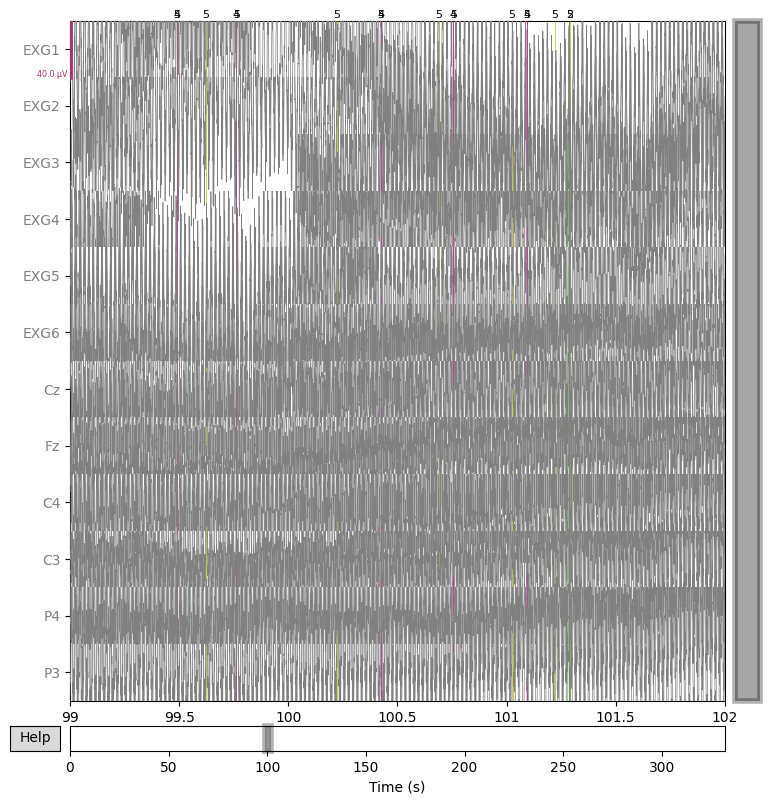

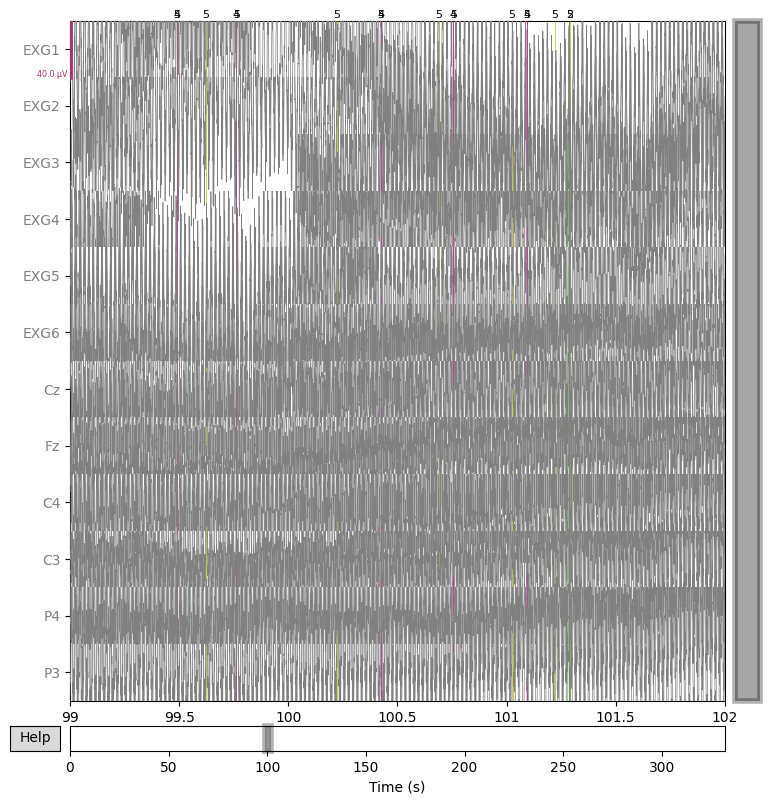

In [6]:
# Define event colors
event_color = {1: "r", 2: "g", 3: "b", 4: "m", 5: "y", 6: "k", 7: "c"}

# Plot the data with events
all_events_arr = np.asarray(all_events)
raw_specific_channels.plot(
        events=all_events_arr,
        start=99,  # Start time in seconds
        duration=3,  # Duration in seconds to be plotted
        color="gray",
        event_color=event_color,
    )


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


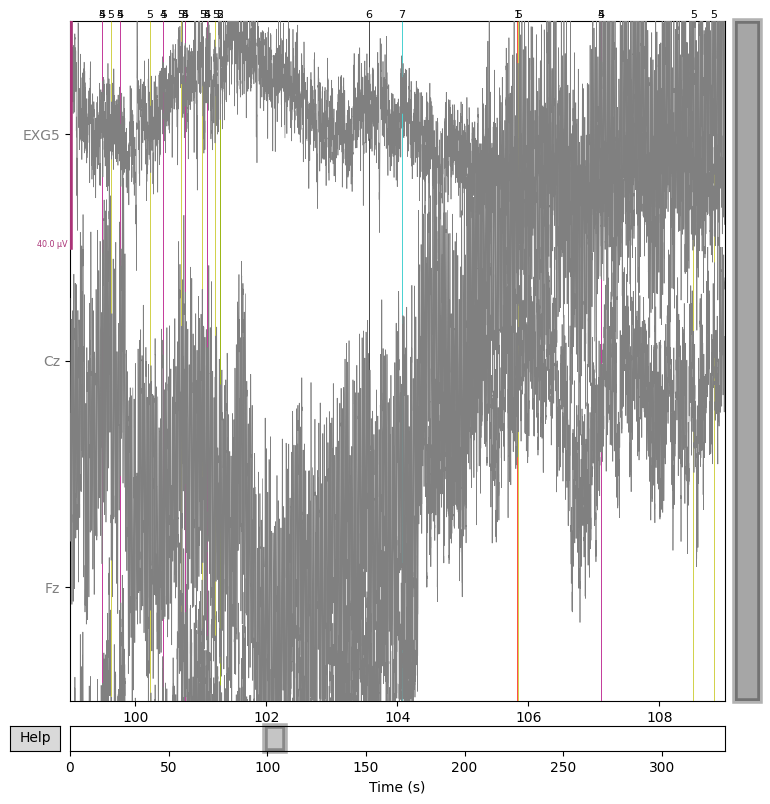

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3381 samples (1.651 s)



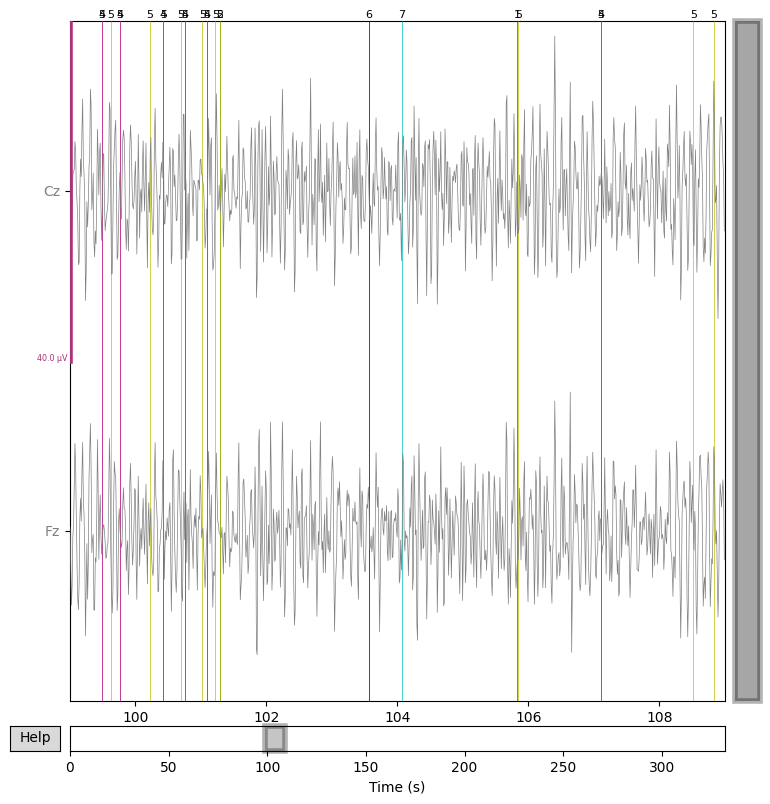

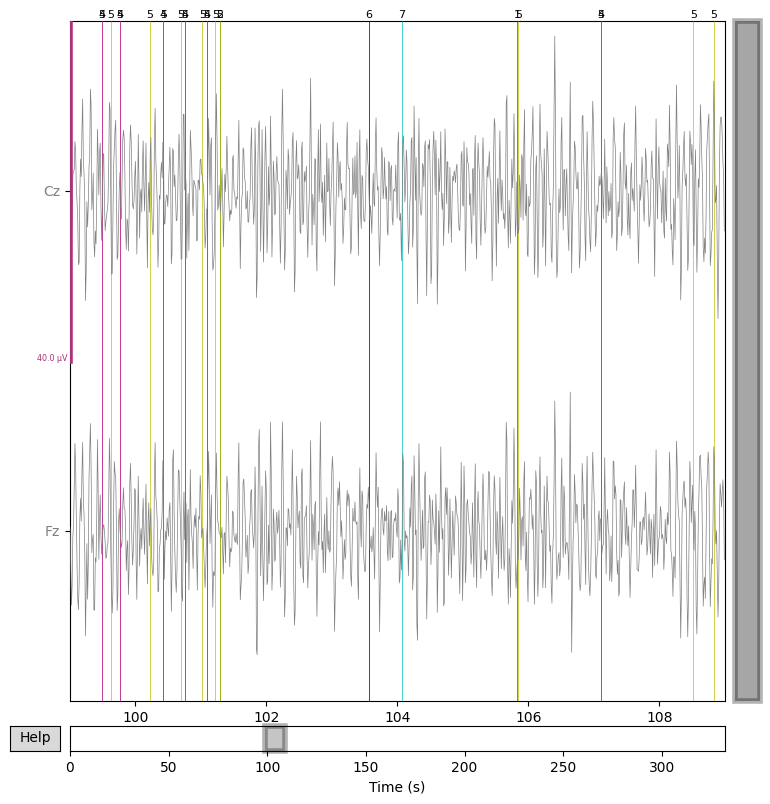

In [7]:
raw_specific_channels.set_eeg_reference(ref_channels=['EXG5','EXG6'])

raw_specific_channels.plot(
        events=all_events_arr,
        start=99,  # Start time in seconds
        duration=10,  # Duration in seconds to be plotted
        color="gray",
        event_color=event_color,
        picks=["Cz","Fz","EXG5"]
    )

raw_specific_channels.filter(7.0, 30.0, fir_design="firwin")
raw_specific_channels.plot(
        events=all_events_arr,
        start=99,  # Start time in seconds
        duration=10,  # Duration in seconds to be plotted
        color="gray",
        event_color=event_color,
        picks=["Cz","Fz"]
    )

In [8]:
raw_specific_channels.set_channel_types({'EXG1':'eog','EXG2':'eog','EXG3':'eog','EXG4':'eog'})

# Define a mapping dictionary from original channel names to standard electrode names
channel_mapping = {
    'EXG5':'A1', 
    'EXG6':'A2'
    # Add more mappings as needed
}

# Rename channels in your raw data using the mapping
raw_specific_channels.rename_channels(channel_mapping)

# Define event IDs for epochs of interest
event_id = {'event_1': 2, 'event_2': 4}  # Replace with your actual event IDs

# Define epoch parameters
tmin, tmax = -0.5, 0.5  # Start and end times in seconds

# Create epochs
epochs = mne.Epochs(raw_specific_channels, all_events, event_id, tmin, tmax, preload=True)

# Label epochs based on event ID
labels = epochs.events[:, -1]

Not setting metadata
209 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 209 events and 2049 original time points ...
0 bad epochs dropped


In [9]:
labels

array([4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 2, 4, 4, 2, 2, 4, 2, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 2, 4, 4, 4, 4, 2, 2, 2, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 2,
       2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 2, 4,
       4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 2, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4,
       2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 2])

In [10]:

total_4 = 0
total_2 = 0
for i in labels:
    if(i==2):
        total_2 = total_2+1
    if(i==4):
        total_4 = total_4+1

In [11]:

def split_epochs_stratified_kfold(epochs, n_splits=5, random_state=None):
    data = epochs.get_data(copy=True)
    labels = epochs.events[:, -1]
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    splits = []
    
    for train_index, test_index in skf.split(data, labels):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        splits.append((X_train, X_test, y_train, y_test))
    
    return splits

In [12]:


avg_true_pos = []
avg_false_pos = []
avg_true_neg = []
avg_false_neg = []
# # Select epochs and labels for the events of interest
epochs_data = epochs.get_data(copy=True)

# # Check for NaNs and Infs
# if np.isnan(epochs_data).sum() > 0 or not np.isfinite(epochs_data).all():
#     raise ValueError("Data contains NaNs or infinite values.")
    


# # Split data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(epochs_data, labels, test_size=0.2, random_state=42)
accuracies = []
true_pos = []
false_pos = []
true_neg = []
false_neg = []
splits = split_epochs_stratified_kfold(epochs, n_splits=5, random_state=42)
for X_train, X_test, y_train, y_test in splits:
    print(f"train_data_length = {len(X_train)}")
    print(f"test_data_length = {len(X_test)}")
    # Initialize CSP
    
    csp = CSP(n_components=4, reg='ledoit_wolf', log=True, norm_trace=False)

    # Create a classification pipeline with CSP and LDA
    clf = Pipeline([('CSP', csp), ('LDA', LDA())])

    # Train the classifier
    clf.fit(X_train, y_train)

    # Test the classifier
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(y_test)
    print(y_pred)
    tp=0
    tn=0
    fp=0 
    fn=0
    for yt,yp in zip(y_test,y_pred):
        if((yt==2)and(yp==2)):
            tp = tp+1
        elif((yt==2)and(yp==4)):
            fn = fn+1
        elif((yt==4)and(yp==4)):
            tn = tn+1
        elif((yt==4)and(yp==2)):
            fp = fp+1
    print(f"tp - {tp}")
    print(f"fn - {fn}")
    print(f"tn - {tn}")
    print(f"fp - {fp}")

    if(tp!=0):
        true_pos.append((tp/(tp+fp))) 
    else:
        true_pos.append(0.0) 
    if(fp!=0):
        false_pos.append((fp/(tp+fp)))  
    else:
        false_pos.append(0.0) 
    if(tn!=0):
        true_neg.append((tn/(tn+fn)))  
    else:
        true_pos.append(0.0) 
    if(fn!=0):
        false_neg.append((fn/(tn+fn))) 
    else:
        true_pos.append(0.0) 
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
average_accuracy = np.mean(accuracies)
average_true_pos = np.mean(true_pos)
average_true_neg = np.mean(true_neg)
average_false_pos = np.mean(false_pos)
average_false_neg = np.mean(false_neg)
print(f"average_accuracy - {average_accuracy}")
avg_true_pos.append(average_true_pos)
avg_false_pos.append(average_false_pos)
avg_true_neg.append(average_true_neg)
avg_false_neg.append(average_false_neg)


train_data_length = 167
test_data_length = 42
Computing rank from data with rank=None
    Using tolerance 1.9e-05 (2.2e-16 eps * 12 dim * 7.3e+09  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       0.71      0.83      0.77         6
           4       0.97      0.94      0.96        36

    accuracy                           0.93        42
   macro avg       0.84      0.89      0.86        42
weighted avg       0.93      0.93      0.93        42

[4 4 4 4 4 4 4 2 4 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 4 4 4 4 4 2 2 4 4 4
 2 4 4 4 4]
[4 4 4 2 4 4 4 2 4 2 4 4 4 4 4 4 4 4 4 4 4 2 4 4 4 4 2 4 4 4 4 4 2 2 4 4 4
 4 4 4 4 4]
tp - 5
fn - 1
tn - 34
fp - 2
train_data_length = 167
test_data_length = 42
Computing rank from

In [13]:
avg_false_pos

[0.29380952380952385]

In [14]:
average_true_pos

0.7061904761904761

In [15]:
# # Check for NaNs and Infs
# if np.isnan(epochs_data).sum() > 0 or not np.isfinite(epochs_data).all():
#     raise ValueError("Data contains NaNs or infinite values.")

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)


Computing rank from data with rank=None
    Using tolerance 2.2e-05 (2.2e-16 eps * 12 dim * 8.2e+09  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.


array([[-1.08823178e+00, -6.32244248e-01, -5.23963651e+01,
        -7.34343572e-01],
       [-1.00279161e-01, -5.54090506e-01, -5.24239099e+01,
        -4.63611856e-01],
       [ 1.45207542e-01, -9.19085050e-01, -5.23342047e+01,
        -6.77010434e-01],
       [ 1.91006357e-01, -4.20653121e-01, -5.21256928e+01,
        -1.83605304e-01],
       [ 1.75013725e-01, -6.40917611e-01, -5.21377842e+01,
        -1.82149120e-01],
       [-4.95502258e-01, -7.83303266e-01, -5.21714046e+01,
        -3.13382086e-01],
       [-1.08268531e+00, -1.92555802e+00, -5.22632524e+01,
        -6.45857404e-01],
       [-1.14386982e+00, -6.93962511e-01, -5.23142981e+01,
        -6.40913183e-01],
       [-5.65325407e-01, -1.11648710e+00, -5.23927939e+01,
        -7.10362344e-01],
       [-3.93327972e-01, -8.00865486e-01, -5.23860924e+01,
        -4.55564574e-01],
       [-1.28661819e+00, -9.84803725e-01, -5.23377882e+01,
        -4.97007636e-01],
       [-2.76716695e+00, -1.04853931e+00, -5.23810197e+01,
      

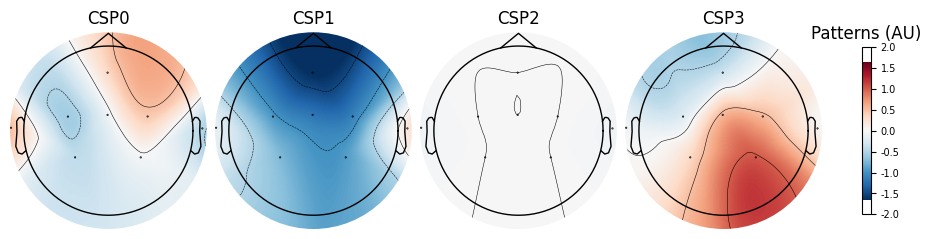

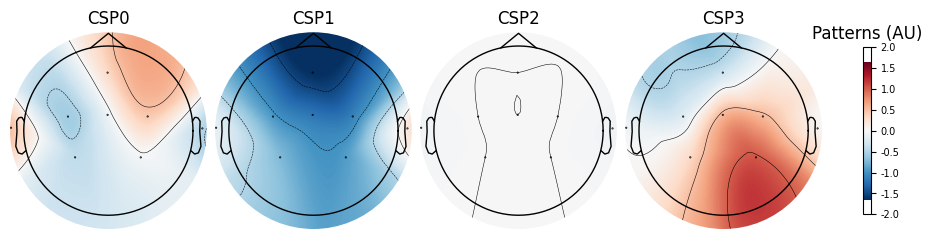

In [16]:


montage = mne.channels.make_standard_montage('standard_1020')
epochs.set_montage(montage)
csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

In [17]:
print(raw_specific_channels.info)


<Info | 9 non-empty values
 bads: []
 ch_names: EXG1, EXG2, EXG3, EXG4, A1, A2, Cz, Fz, C4, C3, P4, P3
 chs: 4 EOG, 8 EEG
 custom_ref_applied: True
 highpass: 7.0 Hz
 lowpass: 30.0 Hz
 meas_date: 2024-05-03 12:40:04 UTC
 nchan: 12
 projs: []
 sfreq: 2048.0 Hz
 subject_info: 1 item (dict)
>


In [18]:
all_threshold = [0.0]
def conv_sample_to_time(sample_id):
    return sample_id/2048.0 
for m in range(1,11):
    ignore_events_threshold = m*0.2
    all_threshold.append(ignore_events_threshold)
# ignore_events_threshold = 1.5
    popped_box_events = []
    cleaned_box_events = []
    trial = 0;
    previous_index_2 = 0
    previous_index_4 = 0
    # Iterate through the data and track instances when the value changes
    for [i,x, value] in all_events:
        if value==1:
            cleaned_box_events.append([i,x, value])
            trial+=1
        elif value==7:
            cleaned_box_events.append([i,x, value])
        elif value==2:
            cleaned_box_events.append([i,x, value])
            previous_index_2 = i
        elif value==4:
            cleaned_box_events.append([i,x, value])
            previous_index_4 = i
        elif value==5:
            prev_time = conv_sample_to_time(previous_index)
            curr_time = conv_sample_to_time(i)
            time_diff = curr_time - prev_time
            if previous_value==4 and time_diff<ignore_events_threshold:
                temp = cleaned_box_events.pop()
                popped_box_events.append(temp)
        elif value==3:
            prev_time = conv_sample_to_time(previous_index_2)
            curr_time = conv_sample_to_time(i)
            time_diff = curr_time - prev_time
            if time_diff<ignore_events_threshold:
                temp = cleaned_box_events.pop()
                popped_box_events.append(temp)
        elif value==6:
            prev_time = conv_sample_to_time(previous_index_2)
            curr_time = conv_sample_to_time(i)
            time_diff = curr_time - prev_time
            if time_diff<ignore_events_threshold:
                temp = cleaned_box_events.pop()
                popped_box_events.append(temp)
        

        previous_value = value
        previous_index = i

    print(cleaned_box_events)

    # Create epochs
    epochs = mne.Epochs(raw_specific_channels, cleaned_box_events, event_id, tmin, tmax, preload=True)
    # Create epochs using popped data
    epochs_2 = mne.Epochs(raw_specific_channels, popped_box_events, event_id, tmin, tmax, preload=True)
    data2 = epochs.get_data(copy=True)
    labels2 = epochs.events[:, -1]
    # Label epochs based on event ID
    labels = epochs.events[:, -1]


    #count false_neg and true_neg from omitted by threshold
    cur_4 = 0
    cur_2 = 0
    for i in labels:
        if(i==2):
            cur_2 = cur_2+1
        if(i==4):
            cur_4 = cur_4+1

    buf_fn = total_2 - cur_2
    buf_tn = total_4 - cur_4

    accuracies =[]
    true_pos = []
    false_pos = []
    true_neg = [buf_tn]
    false_neg = [buf_fn]


    splits = split_epochs_stratified_kfold(epochs, n_splits=5, random_state=42)
    for X_train, X_test, y_train, y_test in splits:
        print(f"train_data_length = {len(X_train)}")
        print(f"test_data_length = {len(X_test)}")
        # Initialize CSP

        csp = CSP(n_components=4, reg='ledoit_wolf', log=True, norm_trace=False)

        # Create a classification pipeline with CSP and LDA
        clf = Pipeline([('CSP', csp), ('LDA', LDA())])
        # Combine the original training data with the new training data
        X_train_combined = np.concatenate((X_train, data2), axis=0)
        y_train_combined = np.concatenate((y_train, labels2), axis=0)
        # Train the classifier
        clf.fit(X_train_combined, y_train_combined)

        # Test the classifier
        y_pred = clf.predict(X_test)
        print(classification_report(y_test, y_pred))
        print(y_test)
        print(y_pred)
        tp=0
        tn=0
        fp=0 
        fn=0
        for yt,yp in zip(y_test,y_pred):
            if((yt==2)and(yp==2)):
                tp = tp+1
            elif((yt==2)and(yp==4)):
                fn = fn+1
            elif((yt==4)and(yp==4)):
                tn = tn+1
            elif((yt==4)and(yp==2)):
                fp = fp+1
        print(f"tp - {tp}")
        print(f"fn - {fn}")
        print(f"tn - {tn}")
        print(f"fp - {fp}")

        true_pos.append(tp) 
        false_pos.append(fp)  
        true_neg.append(tn)  
        false_neg.append(fn) 



        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    average_accuracy = np.mean(accuracies)
    
    average_true_pos = np.sum(true_pos)/(np.sum(true_pos)+np.sum(false_pos))
    average_true_neg = np.sum(true_neg)/(np.sum(true_neg)+np.sum(false_neg))
    average_false_pos = np.sum(false_pos)/(np.sum(true_pos)+np.sum(false_pos))
    average_false_neg = np.sum(false_neg)/(np.sum(true_neg)+np.sum(false_neg))
    print(f"average_accuracy - {average_accuracy}")
    avg_true_pos.append(average_true_pos*100)
    avg_false_pos.append(average_false_pos*100)
    avg_true_neg.append(average_true_neg*100)
    avg_false_neg.append(average_false_neg*100)




[[185061, 0, 1], [188788, 0, 4], [190854, 0, 4], [191674, 0, 2], [196951, 0, 7], [200970, 0, 1], [204313, 0, 4], [205672, 0, 4], [206349, 0, 4], [207438, 0, 2], [213122, 0, 7], [216736, 0, 1], [219342, 0, 4], [227850, 0, 4], [230487, 0, 2], [247979, 0, 7], [251132, 0, 1], [254538, 0, 4], [256047, 0, 4], [257680, 0, 4], [258492, 0, 4], [259186, 0, 4], [260018, 0, 4], [266879, 0, 7], [270198, 0, 1], [273309, 0, 4], [273874, 0, 4], [274897, 0, 2], [280206, 0, 7], [283564, 0, 1], [285495, 0, 4], [285928, 0, 4], [286083, 0, 4], [288028, 0, 4], [289797, 0, 2], [299816, 0, 2], [305716, 0, 2], [311054, 0, 7], [324218, 0, 1], [329277, 0, 4], [335386, 0, 7], [338812, 0, 1], [341192, 0, 4], [342203, 0, 4], [343504, 0, 4], [344406, 0, 4], [345499, 0, 4], [346319, 0, 4], [352783, 0, 7], [356116, 0, 1], [359435, 0, 4], [362735, 0, 4], [363877, 0, 4], [364978, 0, 2], [366958, 0, 2], [373384, 0, 7], [377771, 0, 1], [379581, 0, 4], [380286, 0, 4], [382443, 0, 4], [383857, 0, 4], [384815, 0, 2], [390076

51 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 51 events and 2049 original time points ...
0 bad epochs dropped
Not setting metadata
158 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 158 events and 2049 original time points ...
0 bad epochs dropped
train_data_length = 40
test_data_length = 11
Computing rank from data with rank=None
    Using tolerance 1.5e-05 (2.2e-16 eps * 12 dim * 5.5e+09  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       0.83      1.00      0.9

Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         2

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7

[2 2 2 4 2 2 4]
[2 2 2 4 2 2 4]
tp - 5
fn - 0
tn - 2
fp - 0
train_data_length = 27
test_data_length = 6
Computing rank from data with rank=None
    Using tolerance 1.2e-05 (2.2e-16 eps * 12 dim * 4.4e+09  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2  

31 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 31 events and 2049 original time points ...
0 bad epochs dropped
Not setting metadata
178 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 178 events and 2049 original time points ...
0 bad epochs dropped
train_data_length = 24
test_data_length = 7
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 12 dim * 4.2e+09  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      1.00      1.00

Done.
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

[2 4 2 2 2 4]
[2 4 2 2 2 4]
tp - 4
fn - 0
tn - 2
fp - 0
train_data_length = 24
test_data_length = 6
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 12 dim * 4.2e+09  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         2

    accuracy                           1.00 

28 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 2049 original time points ...
0 bad epochs dropped
Not setting metadata
181 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 181 events and 2049 original time points ...
0 bad epochs dropped
train_data_length = 22
test_data_length = 6
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 12 dim * 4e+09  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      1.00      1.00  

train_data_length = 23
test_data_length = 5
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 12 dim * 4.1e+09  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         1

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5

[2 4 2 2 2]
[2 4 2 2 2]
tp - 4
fn - 0
tn - 1
fp - 0
train_data_length = 23
test_data_length = 5
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 12 dim * 4.1e+09  max singular value)
    Estimated rank (data): 12
    data: rank 12 compu

In [19]:

avg_true_pos


[0.7061904761904761,
 84.61538461538461,
 91.66666666666666,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0]

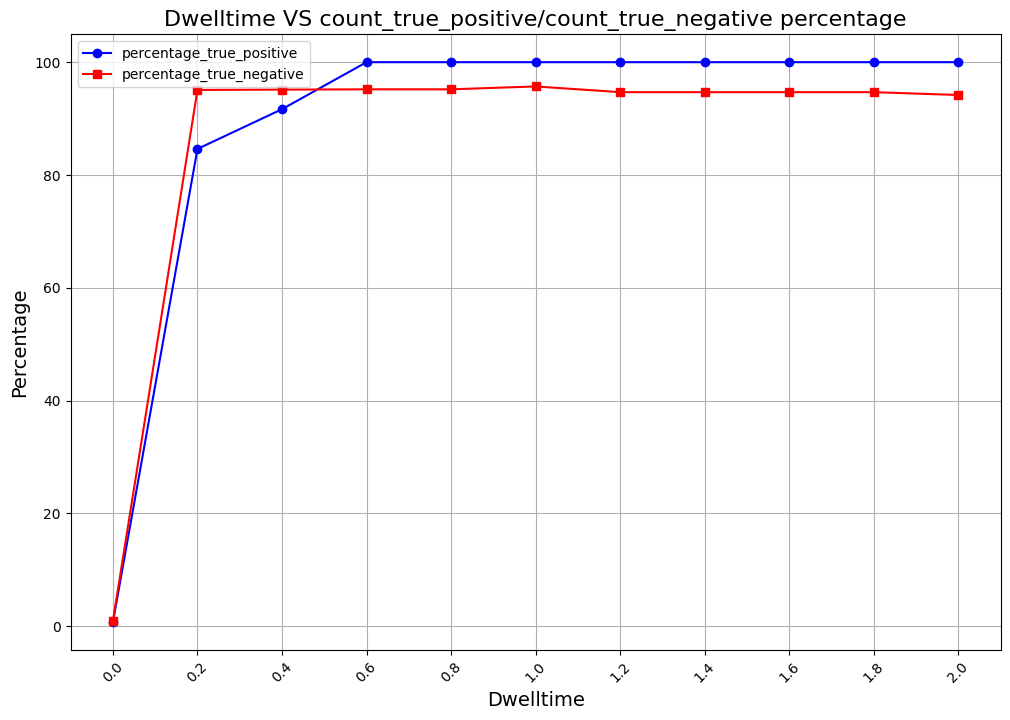

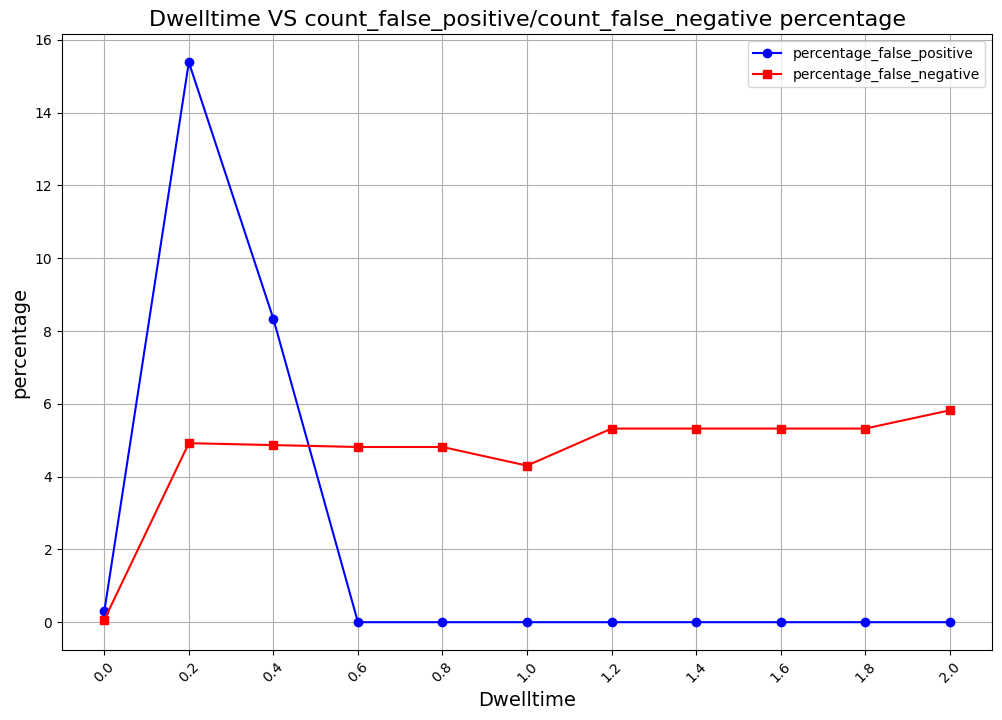

In [23]:
data_for_graph = {
    "Dwelltime":[],
    "count_true_positive":[],
    "count_false_positive":[],
    "count_true_negative":[],
    "count_false_negative":[]
    
}
for m in range(0,11):
    ignore_events_threshold = m*0.2
    data_for_graph["Dwelltime"].append(str(round(ignore_events_threshold,2)))
data_for_graph["count_true_positive"] = avg_true_pos
data_for_graph["count_false_positive"]= avg_false_pos
data_for_graph["count_true_negative"] = avg_true_neg
data_for_graph["count_false_negative"] = avg_false_neg

# Plotting the line chart
plt.figure(figsize=(12, 8))
plt.plot(data_for_graph["Dwelltime"], data_for_graph["count_true_positive"], marker='o', linestyle='-', color='b', label='percentage_true_positive')
plt.plot(data_for_graph["Dwelltime"], data_for_graph["count_true_negative"], marker='s', linestyle='-', color='r', label='percentage_true_negative')

# Adding titles and labels
plt.title('Dwelltime VS true_positive/true_negative percentage', fontsize=16)
plt.xlabel('Dwelltime', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Displaying the chart
plt.show()

# Plotting the line chart
plt.figure(figsize=(12, 8))
plt.plot(data_for_graph["Dwelltime"], data_for_graph["count_false_positive"], marker='o', linestyle='-', color='b', label='percentage_false_positive')
plt.plot(data_for_graph["Dwelltime"], data_for_graph["count_false_negative"], marker='s', linestyle='-', color='r', label='percentage_false_negative')

# Adding titles and labels
plt.title('Dwelltime VS false_positive/false_negative percentage', fontsize=16)
plt.xlabel('Dwelltime', fontsize=14)
plt.ylabel('percentage', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Displaying the chart
plt.show()

In [21]:
# print(len(channel_trigger))
# # Plotting the line chart
# plt.figure(figsize=(12, 8))
# plt.plot(channel_trigger[775936:785936], marker='s', linestyle='-', color='r', label='count_true_negative')

# # Adding titles and labels
# plt.title('Dwelltime VS count_true_positive/count_true_negative percentage', fontsize=16)
# plt.xlabel('Dwelltime', fontsize=14)
# plt.ylabel('Percentage', fontsize=14)
# plt.xticks(rotation=45)
# plt.legend()
# plt.grid(True)

# # Displaying the chart
# plt.show()

In [22]:
# Specify the file name
file_name = 'eeg_data_for_graph.json'

# Save the dictionary to a file
with open(file_name, 'w') as file:
    json.dump(data_for_graph, file)